In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
plt.rcParams['text.usetex'] = False
%matplotlib inline

In [3]:
def readFile(filename, data):
    with open(filename) as csvfile: 
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            row = [i for i in row if i] # remove empty spaces from row
            data.append(row)
        data.pop(0)
    return data

def getExpData(dataList):
    outputSet = set()
    results = []
    result = []
    #for every row in data
    for i in range(0, len(dataList)):
        #if output is already in set
        if dataList[i][2] in outputSet:
            #add row to result
            result.append([dataList[i][0], dataList[i][1]])
        else:
            #add result to results
            if len(result) > 0:
                results.append(result)
            result = [] #reset result list
            #add row to result
            result.append([dataList[i][0], dataList[i][1]])
            outputSet.add(dataList[i][2]) #add output to output set
    results.append(result)
    outputList = list(outputSet)
    outputList = list(map(float, outputList))
    outputList = sorted(outputList, key = lambda x:float(x))
    return outputList, results

def getTimeTemp(outputList, results):
    time = []
    temp = []
    for i in range(0, len(outputList)):
        resultArrs = np.array(results[i]).T
        timeList = resultArrs[0]
        tempList = resultArrs[1]
        timeList = list(map(float, timeList))
        tempList = list(map(float, tempList))
        time.append(np.array(timeList) - timeList[0])
        temp.append(np.array(tempList))
    return time, temp

def fo(t, K, tau, y0=0):
    #https://github.com/alchemyst/Dynamics-and-Control/blob/master/tbcontrol/responses.py
    # First Order response with bias
    return y0 + np.sign(K)*np.maximum(0, abs(K)*(1 - np.exp(-(t - np.min(t))/tau)))
    #return y0 + np.sign(K)*abs(K)*(1 - np.exp(-(t - np.min(t))/tau))
    #return y0 + K*(1 - np.exp(-(t - np.min(t))/tau))

def expFit(x, y0, a, b):
    return y0 + a**(x * b)
    
def resultplot(time, K, tau, y0):
    #plt.scatter(time, temp)
    time = np.array(time)
    ax1.plot(time, fo(time, K, tau, y0), color='black')
    
def calcGradParams(temp, gradients, outputList):
    gradParams = []
    for i in range(0, len(outputList)):
        #print(np.shape(temp[i]), np.shape(gradients[i]))
        gradParams.append(np.polyfit(temp[i][1:], gradients[i], 1))
    return gradParams

def calcDeltaT(out, currentTemp, slopeFit, interceptFit):
    #calcSlope = out * slopeFit[0] + slopeFit[1]
    #calcIntercept = out * interceptFit[0] + interceptFit[1]
    #DeltaT = calcSlope * currentTemp + calcIntercept
    DeltaT = slopeFit(out) * currentTemp + interceptFit(out)
    #DeltaT = expFit(out, y0Slope, aSlope, bSlope) * currentTemp + expFit(out, y0Int, aInt, bInt)
    return DeltaT

def runSim(T0, endTime, out, slopeFit, interceptFit):
    dt = 0.1 #Time step in seconds
    time = [] #time list
    temp = [T0] #Average block temp under heater
    gradient = [] #Change in temperature over time
    while True:
        if len(time) == 0:
            time.append(0.0)
        else:
            #base 10 rounding avoids accumulated rounding errors from python
            time.append(round(time[-1]+dt,6)) 
        DeltaTemp = calcDeltaT(out, temp[-1], slopeFit, interceptFit)
        temp.append(temp[-1] + DeltaTemp*dt)
        if len(temp) >= 2:
            gradient.append((temp[-1] - temp[-2]) / dt)
        if time[-1] >= endTime:
            steadyTemp_S.append(temp[-1])
            break
        if ((time[-1].is_integer() == True) 
            and (int(time[-1]) % 60 == 0)):
            #print simulation time
            hours = int(time[-1]//(60*60))
            minutes = int(time[-1]/60 - hours * 60)
            if minutes < 10:
                minutes = str(0) + str(minutes)
            if hours < 10:
                hours = str(0) + str(hours)
            timeStamp = str(hours) + ':' + str(minutes)
            #print(timeStamp, end='\r')
    tempChange = steadyTemp_S[-1] - T0
    tauTemp = (1 - np.e ** -1)* tempChange + T0
    for j in range(0, len(time) - 1):
        if temp[j] >= tauTemp:
            tau_S.append(time[j])
            break
    result = [time, temp, gradient]
    return result

In [40]:
run = '9' #which no. run to analyse
path = 'Results/' #path of file
runfile = 'tuningDataNB' + str(run) + '.csv'
pathRunfile = path + runfile
dataList = []
dataList = readFile(pathRunfile, dataList) #read file
outputList, results_E = getExpData(dataList) #organize data
time_E, temp_E = getTimeTemp(outputList, results_E) #get time and temp lists
#print(outputList)
tempFit_E = []
tauFit_E = []
steadyTemp_E = []
gradients_E = []
maxGradients_E = []
minGradients_E = []
results_S=[]
steadyTemp_S=[]
tau_S=[]
T0List=[]

tempDiff = []
maxTempDiff = []
minTempDiff = []
maxTempFit_E = []
minTempFit_E = []
tempFitstddev = []
for i in range(0, len(outputList)):
    [K, tau_E, y0], _ = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i], p0=[0, 600, 100])

    poptTempFit, pcovTempFit = scipy.optimize.curve_fit(fo, time_E[i], temp_E[i], p0=[0, 600, 100])#, sigma=sig, absolute_sigma=True)
    tempFit_E.append(fo(time_E[i], *poptTempFit))

    avgDiff = np.sum(tempFit_E[i] - temp_E[i])/len(temp_E[i])
    tempFitcovsum = 0
    for j in range(0 , len(tempFit_E[i])):
        tempFitcovsum += (tempFit_E[i][j] - temp_E[i][j] - avgDiff)**2
    tempFitstddev.append((tempFitcovsum/len(tempFit_E[i]))**0.5)
    print(i, tempFitstddev[i]) 
    T0List.append(y0)
    steadyTemp_E.append(fo(tau_E, K, tau_E, y0))
    tauFit_E.append(tau_E)

    gradient_E = [] 
    for j in range(1, len(time_E[i])):
        gradient_E.append((tempFit_E[i][j]-tempFit_E[i][j-1])
                          /(time_E[i][j]-time_E[i][j-1]))
    gradients_E.append(gradient_E)

#calc gradient fits for each heater output
gradParams = calcGradParams(temp_E, gradients_E, outputList)

gradFit_E = []
gradFitstddev = []
for i in range(0, len(outputList)):
    gradFit_E.append(gradParams[i][0]*temp_E[i][1:] + gradParams[i][1])
    avgdiff = np.sum(gradFit_E[i] - gradients_E[i])/len(gradients_E[i])
    gradFitcovsum = 0
    for j in range(0 , len(gradFit_E[i])):
        gradFitcovsum += (gradFit_E[i][j] - gradients_E[i][j] - avgDiff)**2
    gradFitstddev.append((gradFitcovsum/len(gradFit_E[i]))**0.5)
    #print(i, "avgDiff", avgDiff, "gradFitcovsum", gradFitcovsum, "gradFitstddev[i]", gradFitstddev[i])
    
time_S, temp_S, gradient_S = [],[],[]
slopes=[]
intercepts=[]
for params in gradParams:
    slopes.append(params[0])
    intercepts.append(params[1])


slopeFit = np.poly1d(np.polyfit(outputList, slopes, 2))
interceptFit = np.poly1d(np.polyfit(outputList, intercepts, 2))

slope_R2 = r2_score(slopes, slopeFit(outputList))
intercept_R2 = r2_score(intercepts, interceptFit(outputList))

print('slope R^2: ', slope_R2, ' intercept R^2: ', intercept_R2)

for i in range(0, len(outputList)):
    result_S = runSim(T0List[i], time_E[i][-1], outputList[i], 
                      slopeFit, interceptFit)
    time_S.append(result_S[0])
    temp_S.append(result_S[1])
    gradient_S.append(result_S[2])

0 0.018994309966661193
1 0.029049652226825092
2 0.026299606220038383
3 0.015925401368981112
slope R^2:  0.9530147761297105  intercept R^2:  0.948720037124876


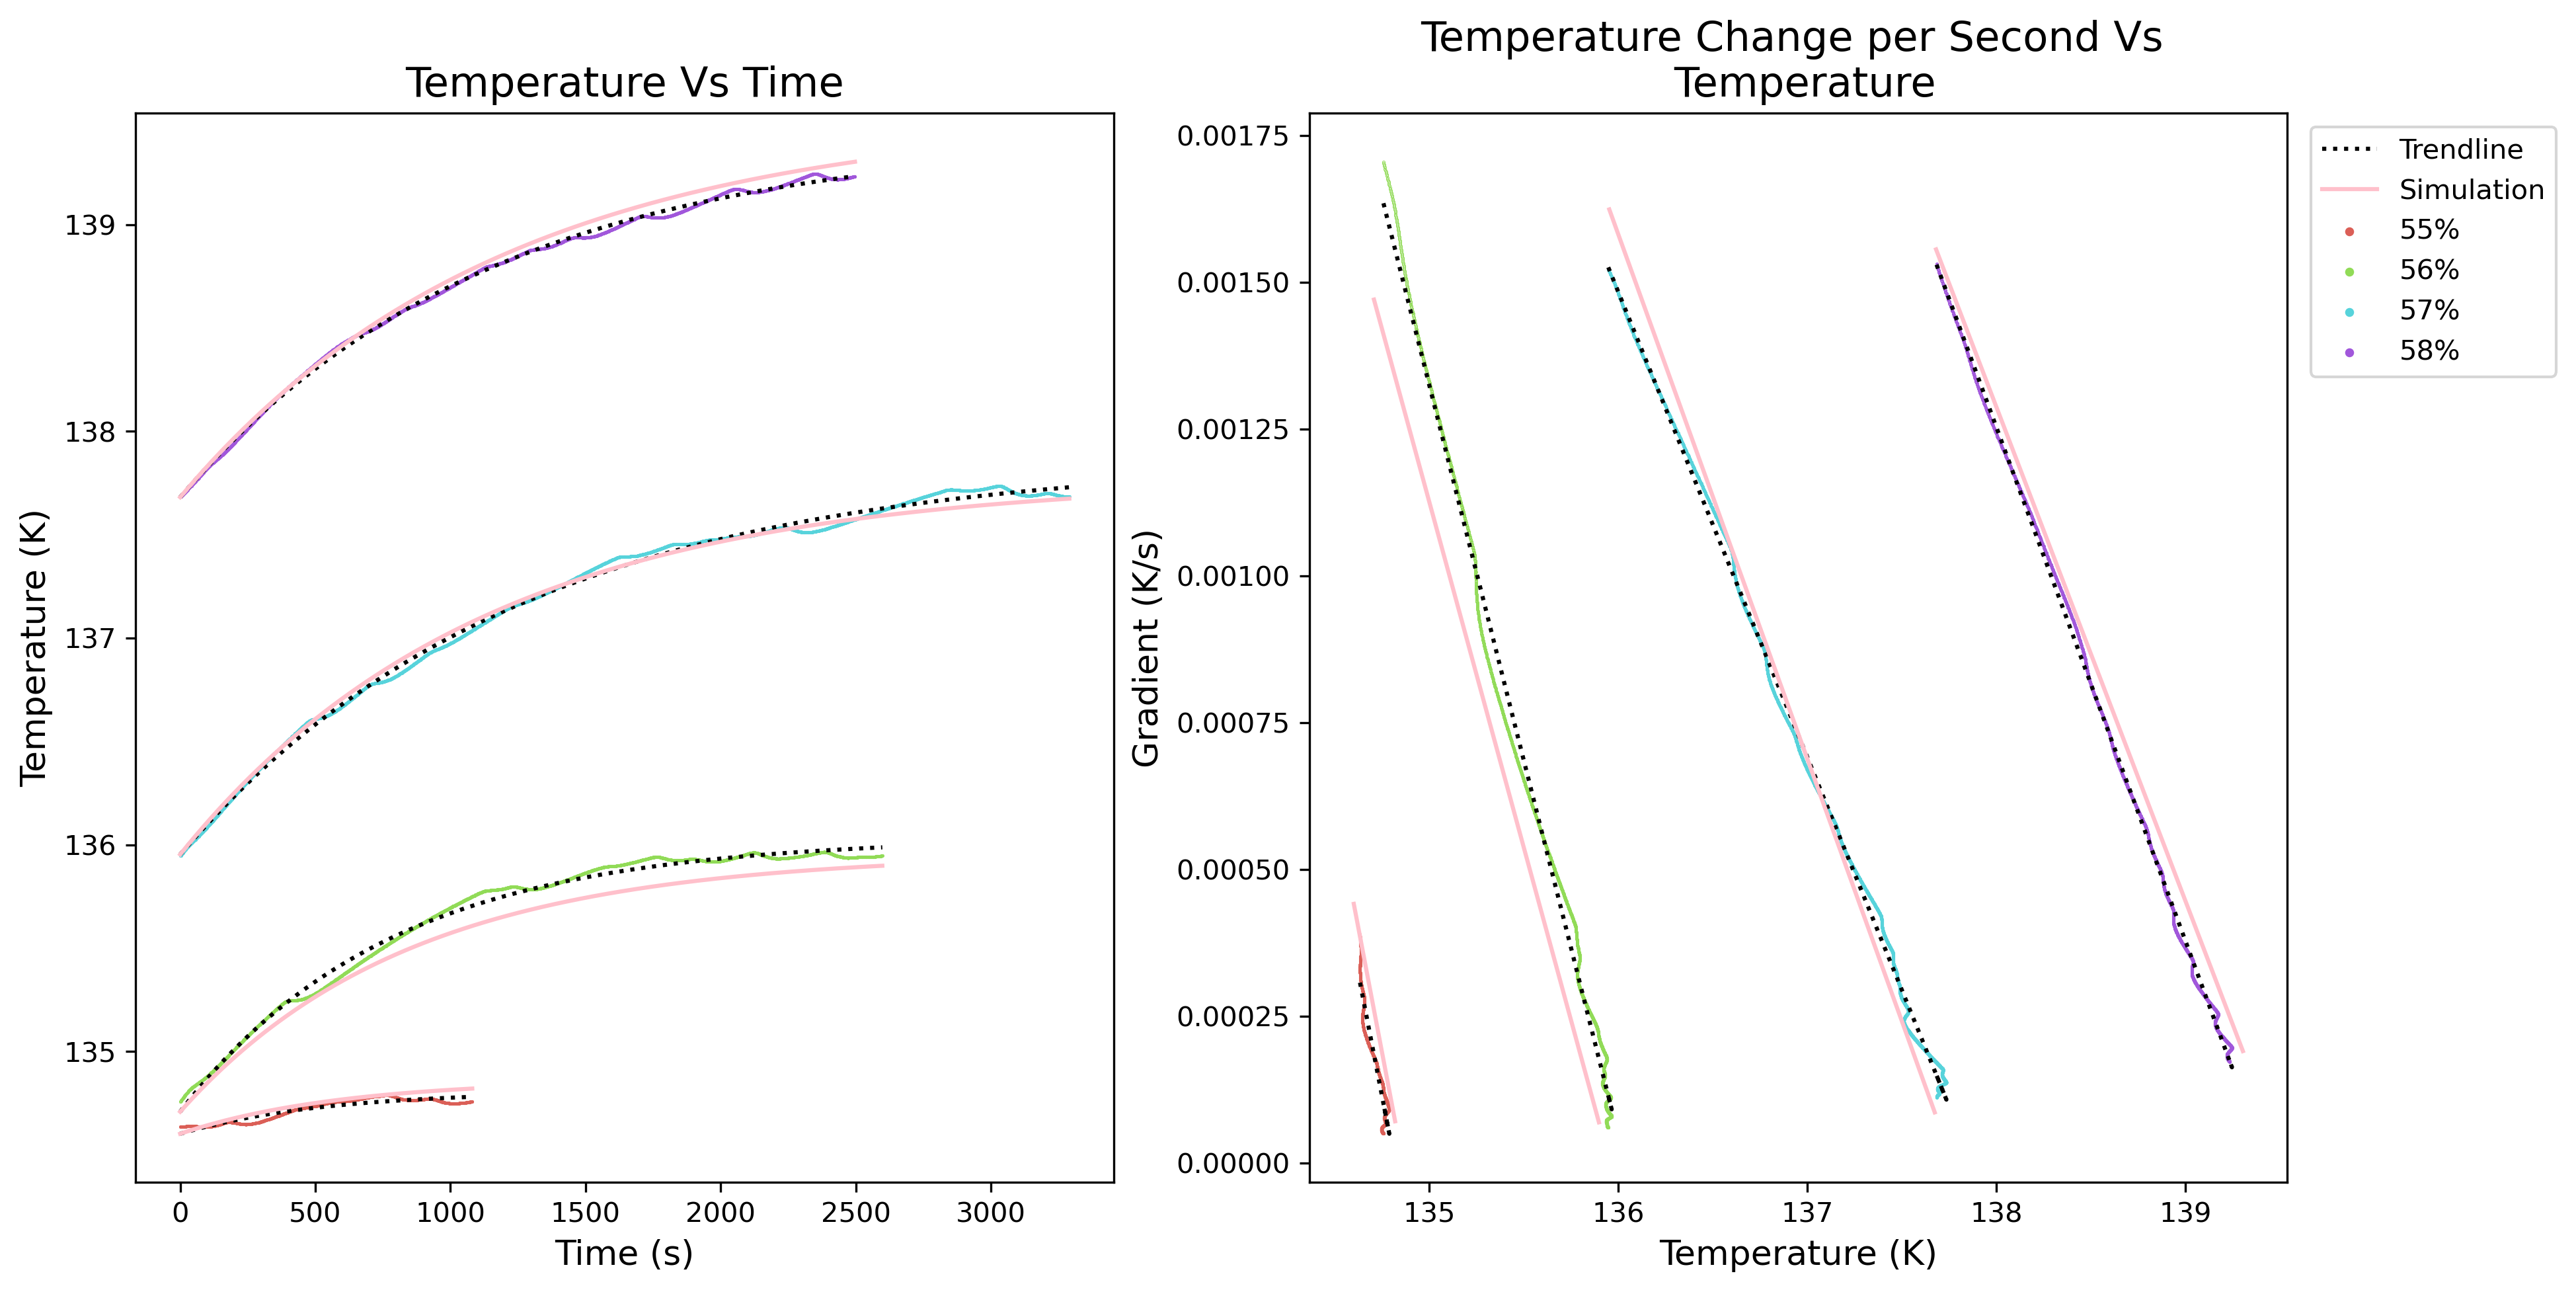

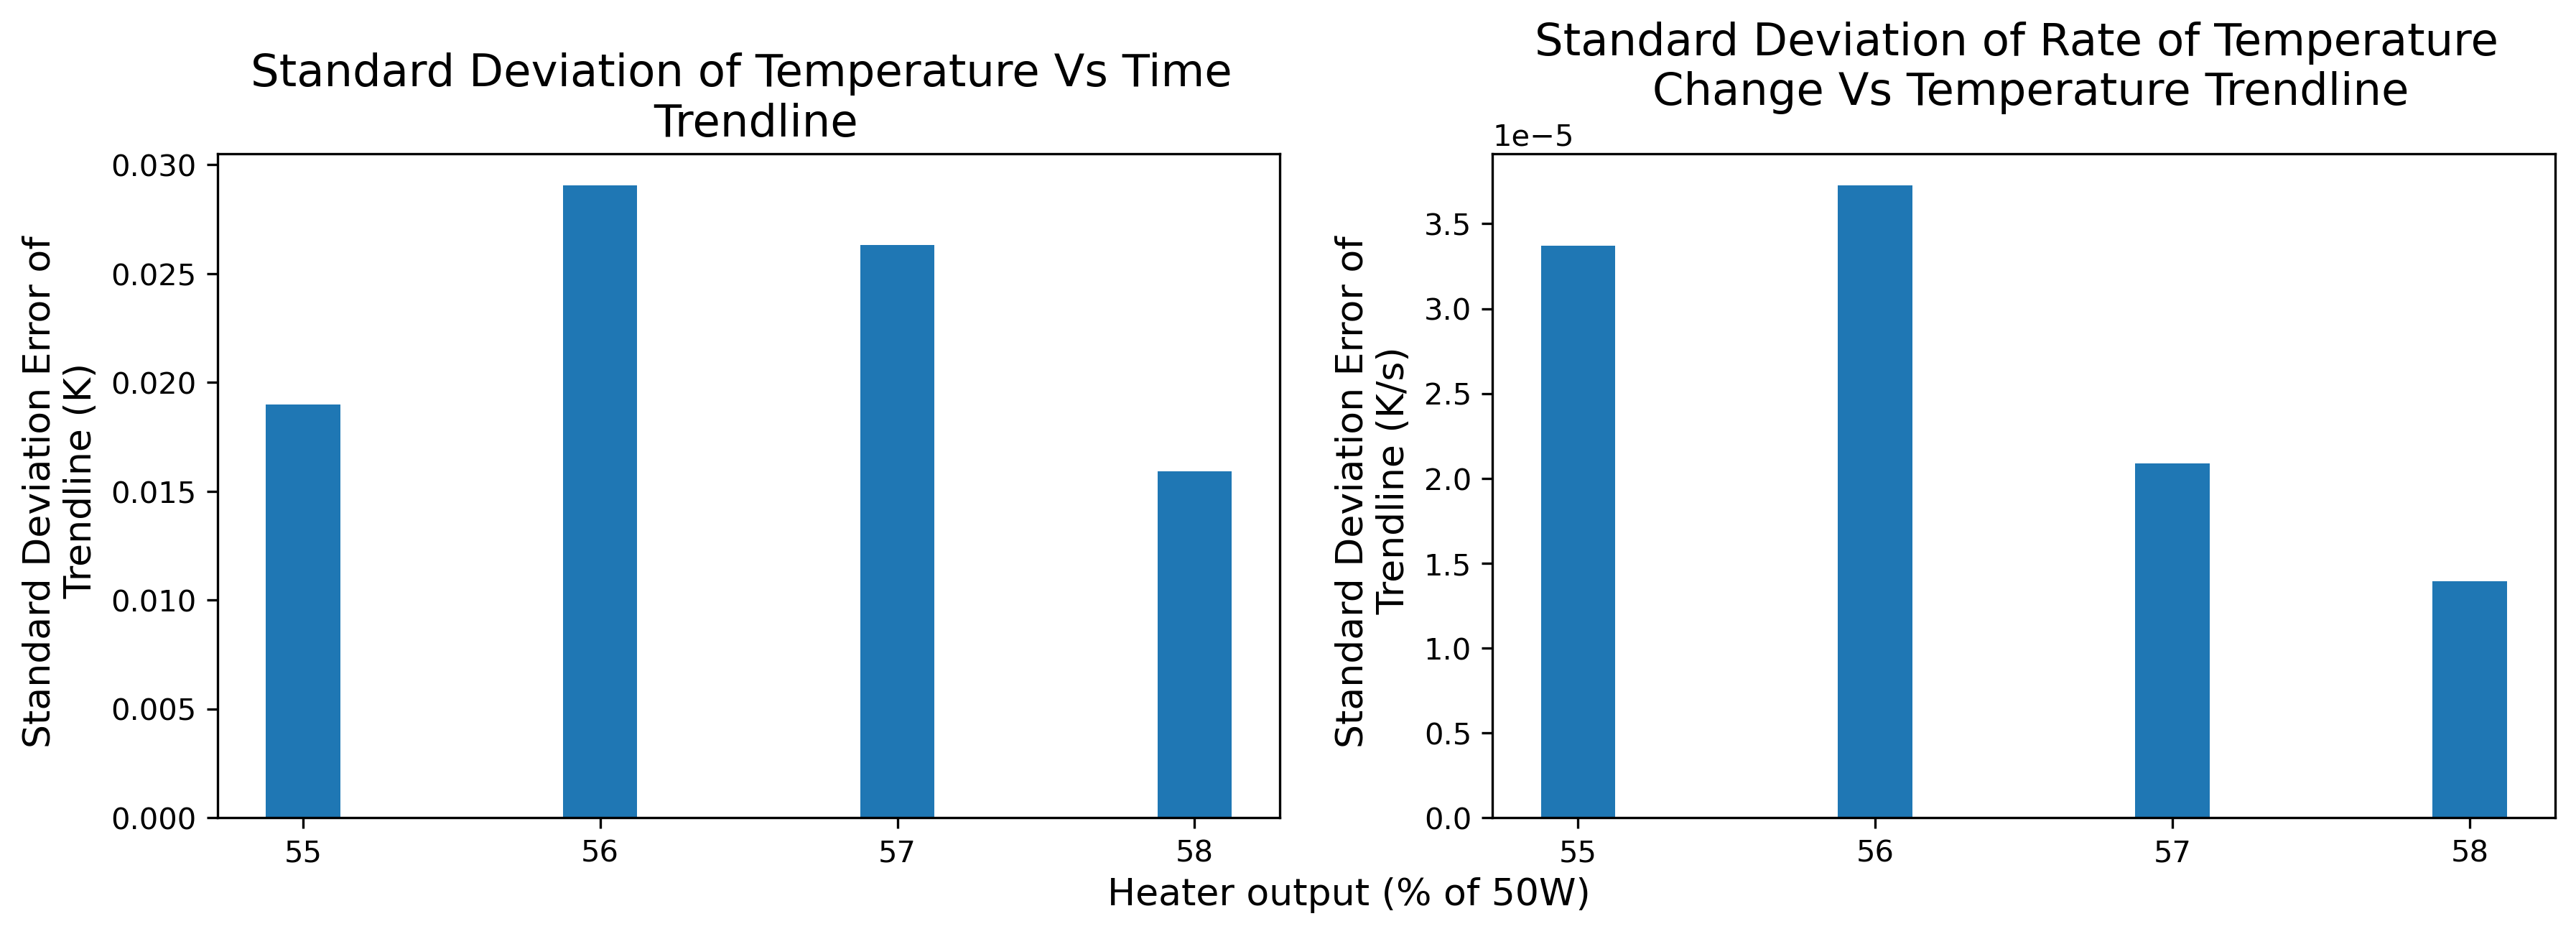

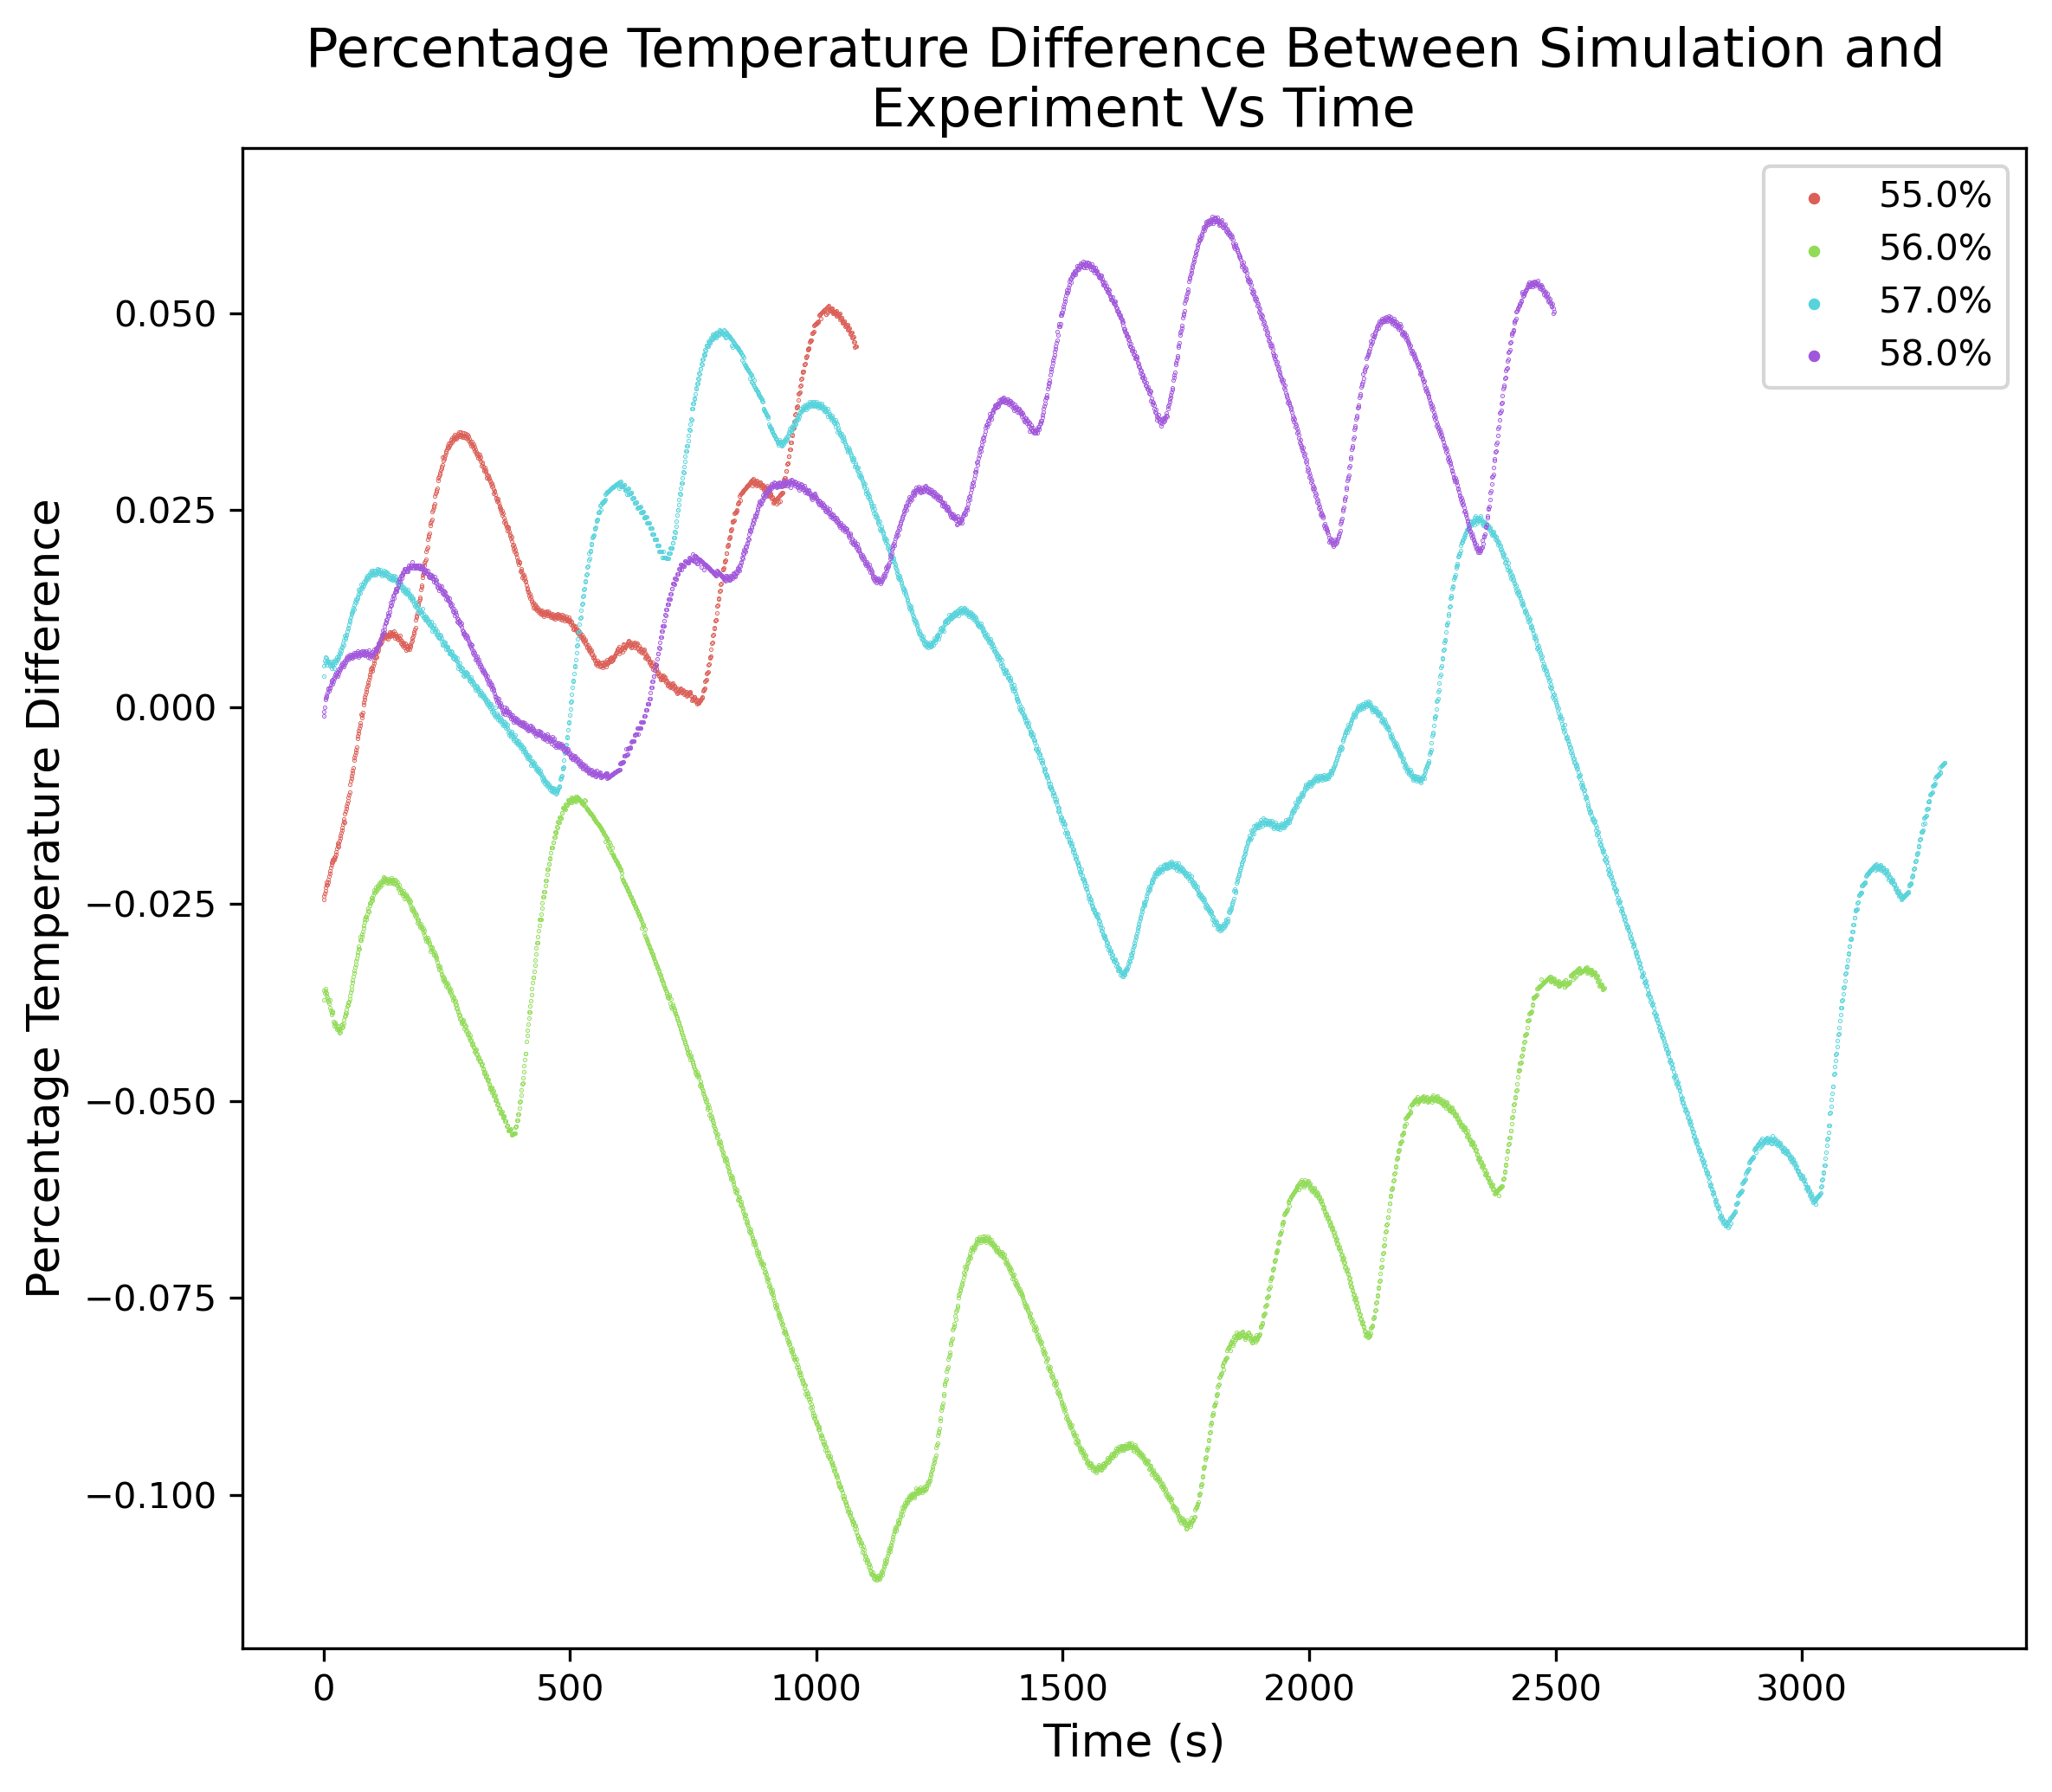

In [42]:
from scipy.interpolate import interp1d
fig1, ax1 = plt.subplots(1,2, figsize=(14,7), dpi=300)
colors = sns.color_palette('hls', len(outputList))
ax1[0].set_prop_cycle('color', colors)
ax1[1].set_prop_cycle('color', colors)
ax1[0].set_title('Temperature Vs Time', fontsize=15)
ax1[0].set_xlabel('Time (s)', fontsize=12.5)
ax1[0].set_ylabel('Temperature (K)', fontsize=12.5)

for i in range(0, len(outputList)):
    ax1[0].scatter(time_E[i], temp_E[i], label=str(round(outputList[i]))+'%', s=0.05)
    ax1[0].plot(time_E[i], tempFit_E[i], color='black', linestyle=':')
    #ax1[0].fill_between(time_E[i], np.array(tempFit_E[i]) - tempFitstddev[i], np.array(tempFit_E[i]) + tempFitstddev[i], color='tab:grey', alpha=0.5)
    if i == 1:
        ax1[0].plot(time_S[i], temp_S[i][:-1], color='pink', 
                    label='Simulation')
    else:
        ax1[0].plot(time_S[i], temp_S[i][:-1], color='pink')
        
ax1[1].set_title('Temperature Change per Second Vs \n Temperature', fontsize=15)
ax1[1].set_xlabel('Temperature (K)', fontsize=12.5)
ax1[1].set_ylabel('Gradient (K/s)', fontsize=12.5)

for i in range(0, len(outputList)):  
    #gradParams_x = np.linspace(100,130,1000)
    if i == 0:
        ax1[1].plot(temp_E[i][1:], gradFit_E[i], color='black', linestyle=':', 
                    label='Trendline')
        ax1[1].plot(temp_S[i][:-1], gradient_S[i], color='pink', 
                    label='Simulation')
    else:
        ax1[1].plot(temp_E[i][1:], gradFit_E[i], color='black', linestyle=':') 
        ax1[1].plot(temp_S[i][:-1], gradient_S[i], color='pink') 
    ax1[1].scatter(temp_E[i][1:], gradients_E[i], label=str(round(outputList[i]))+'%', s=0.05)
    #ax1[1].fill_between(temp_E[i][1:], np.array(gradFit_E[i]) - gradFitstddev[i], np.array(gradFit_E[i]) + gradFitstddev[i], color='tab:grey', alpha=0.5)
ax1[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1), markerscale=10)

fig4, ax4 = plt.subplots(1, 2, figsize=(14,4), dpi=300)
ax4[0].bar(outputList, tempFitstddev, width=0.25)
ax4[1].bar(outputList, gradFitstddev, width=0.25)
#ax4[0].set_xlabel('Heater output (% of 50W)', fontsize=12.5)
#ax4[1].set_xlabel('Heater output (% of 50W)', fontsize=12.5)
fig4.supxlabel('Heater output (% of 50W)', fontsize=12.5, y=0)
ax4[0].set_xticks(outputList)
ax4[1].set_xticks(outputList)
ax4[0].set_ylabel('Standard Deviation Error of \n Trendline (K)', fontsize=12.5)
ax4[1].set_ylabel('Standard Deviation Error of \n Trendline (K/s)', fontsize=12.5)
ax4[0].set_title('Standard Deviation of Temperature Vs Time \n Trendline', fontsize=15)
ax4[1].set_title('Standard Deviation of Rate of Temperature \n Change Vs Temperature Trendline', fontsize=15)

tempInterpListsS = []
percentDiffSE = []
totPercentDiffSE = []
fig2, ax2 = plt.subplots(figsize=(8,7), dpi=300)
colors = sns.color_palette('hls', len(outputList))
ax2.set_prop_cycle('color', colors)
for i in range(0, len(outputList)):
    interpS = interp1d(time_S[i], temp_S[i][:-1]) #want to interpolate the simulation
    tempInterpS = []
    for j in range(0, len(time_E[i])):#interpolate for every experimental time stamp
        tempInterpS.append(interpS(time_E[i][j]))
    tempInterpListsS.append(tempInterpS)#add reselt for list of lists for each output
    percentDiffSE.append(100*(np.array(tempInterpListsS[i]) - np.array(temp_E[i]))/(0.5*(np.array(tempInterpListsS[i]) + np.array(temp_E[i]))))
    totPercentDiffSE.append(100*(sum(np.array(tempInterpListsS[i])) - sum(np.array(temp_E[i])))/(0.5*(sum(np.array(tempInterpListsS[i])) + sum(np.array(temp_E[i])))))
for i in range(0, len(outputList)):
    ax2.scatter(time_E[i], percentDiffSE[i], label=str(round(outputList[i],2))+'%', s=0.05)
ax2.set_xlabel('Time (s)', fontsize=12.5)
ax2.set_ylabel('Percentage Temperature Difference', fontsize=12.5)
ax2.set_title('Percentage Temperature Difference Between Simulation and \n Experiment Vs Time', fontsize=15)
ax2.legend(markerscale=10)

plt.tight_layout()
plt.show()

[]

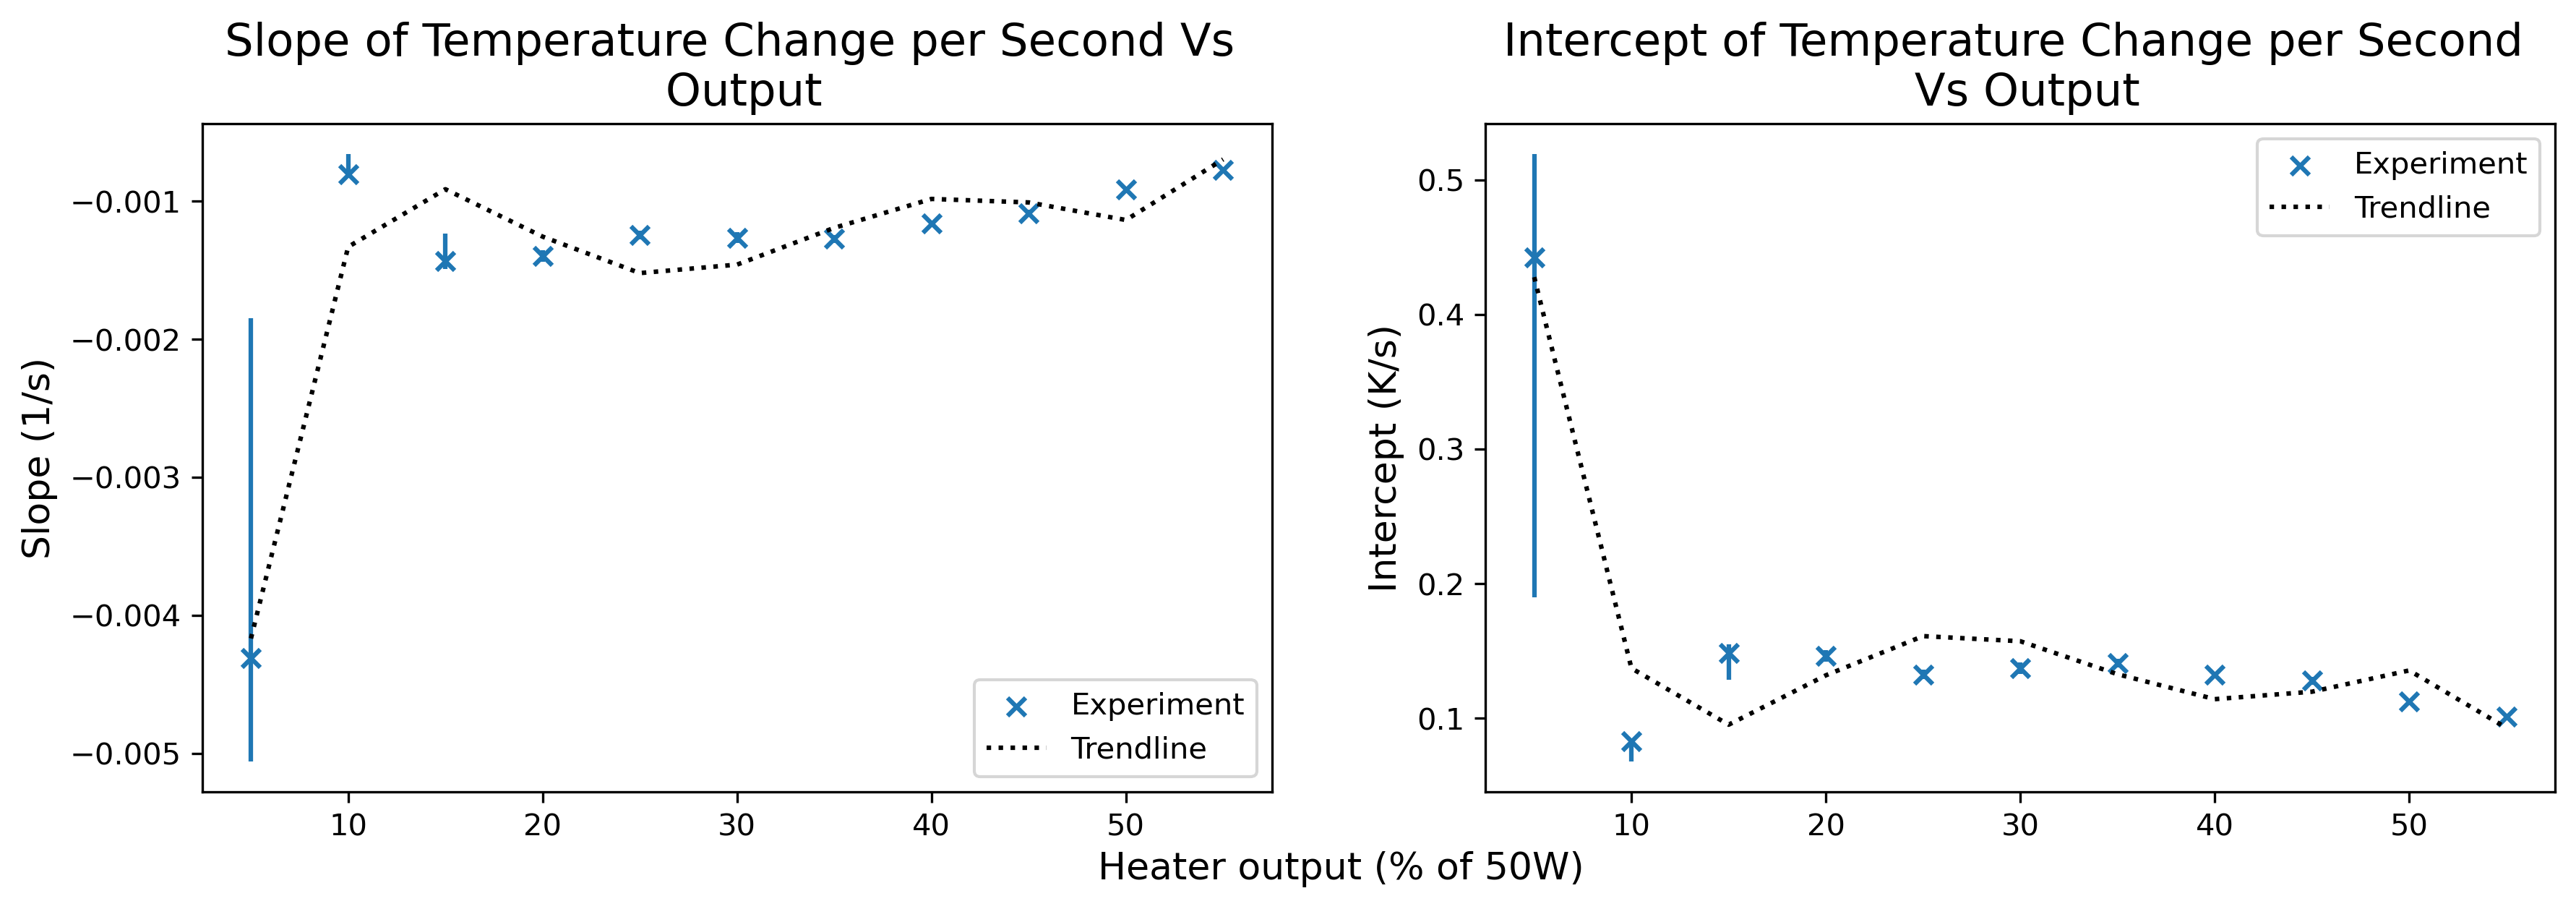

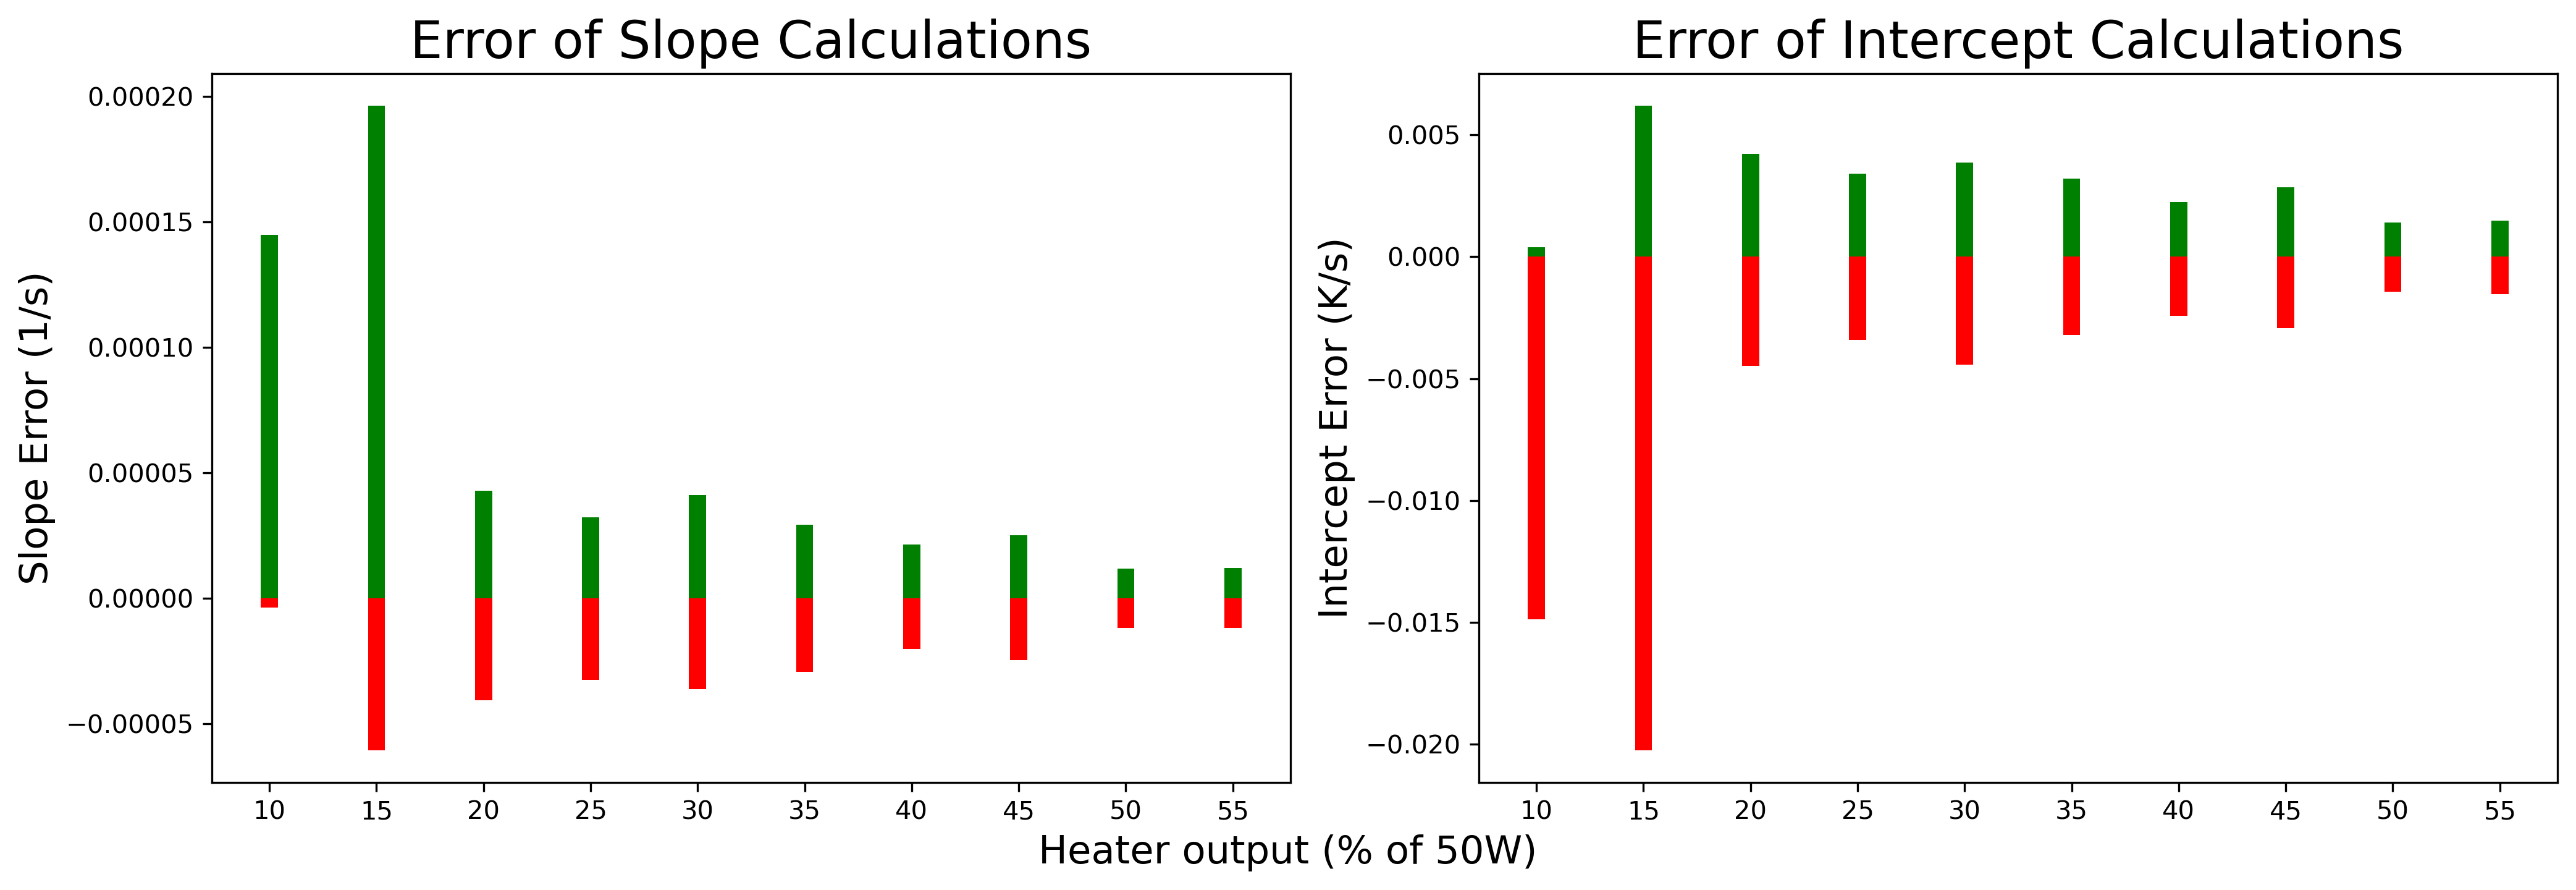

In [38]:
maxSlopes = []
minSlopes = []
maxIntercepts = []
minIntercepts = []

for i in range(0, len(outputList)):
    tempRange = np.max(temp_E[i]) - np.min(temp_E[i])
    minSlopes.append((gradFit_E[i][-1] - gradFit_E[i][0] - 2*gradFitstddev[i])/tempRange)
    maxSlopes.append((gradFit_E[i][-1] - gradFit_E[i][0] + 2*gradFitstddev[i])/tempRange)
    minIntercepts.append(gradFit_E[i][0] - gradFitstddev[i] - maxSlopes[i] * temp_E[i][0])#b = y - mx
    maxIntercepts.append(gradFit_E[i][0] + gradFitstddev[i] - minSlopes[i] * temp_E[i][0])

slopeError = [np.absolute(np.array(minSlopes)-np.array(slopes)), np.absolute(np.array(maxSlopes)-np.array(slopes))]
interceptError = [np.absolute(np.array(minIntercepts)-np.array(intercepts)), np.absolute(np.array(maxIntercepts)-np.array(intercepts))]

fig3, ax3 = plt.subplots(1, 2, figsize=(14,4), dpi=300)
#ax3[0].set_xlabel('Output (% of 50 W)', fontsize=12.5)

ax3[0].set_title('Slope of Temperature Change per Second Vs \n Output', fontsize=15)
ax3[0].set_ylabel('Slope (1/s)', fontsize=12.5)
ax3[0].scatter(outputList, slopes, marker='x', label='Experiment')
ax3[0].errorbar(outputList, slopes, yerr=slopeError, fmt='none')
ax3[0].plot(outputList, slopeFit(outputList), color='black', linestyle=':', label='Trendline')
ax3[0].legend(loc='lower right')
#ax3[1].set_xlabel('Output (% of 50 W)', fontsize=12.5)
fig3.supxlabel('Heater output (% of 50W)', fontsize=12.5, y=0)
ax3[1].set_title('Intercept of Temperature Change per Second \n Vs Output', fontsize=15)
ax3[1].set_ylabel('Intercept (K/s)', fontsize=12.5)
ax3[1].scatter(outputList, intercepts, marker='x', label='Experiment')
ax3[1].errorbar(outputList, intercepts, yerr=interceptError, fmt='none')
ax3[1].plot(outputList, interceptFit(outputList), color='black', linestyle=':', label='Trendline')
ax3[1].legend()

fig5, ax5 = plt.subplots(1, 2, figsize=(14,5), dpi=300)
ax5[0].bar(outputList[1:], slopeError[1][1:], color='g')
ax5[0].bar(outputList[1:], -slopeError[0][1:], color='r')
ax5[1].bar(outputList[1:], interceptError[1][1:], color='g')
ax5[1].bar(outputList[1:], -interceptError[0][1:], color='r')
ax5[0].set_xticks(outputList[1:])
ax5[1].set_xticks(outputList[1:])
#ax5[0].bar(outputList, slopeError[1], color='g')
#ax5[0].bar(outputList, -slopeError[0], color='r')
#ax5[1].bar(outputList, interceptError[1], color='g')
#ax5[1].bar(outputList, -interceptError[0], color='r')
#ax5[0].set_xticks(outputList)
#ax5[1].set_xticks(outputList)
fig5.supxlabel('Heater output (% of 50W)', fontsize=15, y=0.05)
ax5[0].set_ylabel('Slope Error (1/s)', fontsize=15)
ax5[1].set_ylabel('Intercept Error (K/s)', fontsize=15)
ax5[0].set_title('Error of Slope Calculations', fontsize=20)
ax5[1].set_title('Error of Intercept Calculations', fontsize=20)

plt.tight_layout()
plt.plot()

In [17]:
print(outputList[0], slopeError[0][0], slopeError[1][0])
print(outputList[1], slopeError[0][1], slopeError[1][1])

print(outputList[0], interceptError[0][0], interceptError[1][0])
print(outputList[1], interceptError[0][1], interceptError[1][1])

55.0 0.00010281258943321782 0.0007670709230015066
56.0 4.161665542119731e-05 8.187207586288561e-05
55.0 0.10330830170441468 0.01387588096444814
56.0 0.011070261795871589 0.005645481592570084


In [31]:
### FITTING RESULTS
percentDiffAll = []
percentRMSAll = 0
for i in range(0, len(outputList)):
    percentDiffAll.extend(percentDiffSE[i])
    #percentRMS = np.sqrt(np.mean(np.square(np.array(percentDiffSE[i]))))
    #percentRMSAll += percentRMS

percentRMSAvg = np.sqrt(np.mean(np.square(np.array(percentDiffAll))))
#print(percentRMSAll)
#percentRMSAvg = percentRMSAll/len(outputList)
print("min error: ", min(np.array(percentDiffAll)), "max error: ", max(np.array(percentDiffAll)))
print("average RMS error: ", percentRMSAvg)

min error:  -2.7719827574755835 max error:  7.707518323909127
average RMS error:  1.9262123825934083


In [32]:
def plotTemperature(time, setpoint, temp):
    fig5 = plt.figure()
    ax5 = plt.gca()
    #plt.axhline(y=target, color='black')
    plt.plot(time, temp[:-1], label='temp', color='tab:purple')
    plt.plot(time, setpoint[:-1], label='setpoint', color='black', linestyle=':')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.legend(loc='best')
    plt.title('Temperature over time')

def plotController(controlTime, P_out, I_out, D_out, PID_out, duty):
    fig6, ax6 = plt.subplots()
    ax6 = plt.gca()
    plt.plot(controlTime, P_out, label='P output')
    plt.plot(controlTime, I_out, label='I output')
    #plt.plot(controlTime, D_out, label='D_out')
    plt.plot(controlTime, PID_out, label='PI output')
    plt.plot(controlTime, duty, label='Heater % output')
    plt.xlabel('Time(s)')
    plt.ylabel('Output')
    plt.legend(loc='best')
    plt.title("Controller output over time")

def plotError(controlTime, error, intError, gradient):
    fig7, ax7 = plt.subplots(3, 1, figsize=(8,8))
    ax7[0].plot(controlTime, error, label='error')
    ax7[0].set_ylabel('Error (K)')
    ax7[0].legend(loc='best')
    ax7[1].plot(controlTime, intError, label='Accumulated error')
    ax7[1].set_ylabel('Accumulated error (K s)')
    ax7[1].legend(loc='best')
    ax7[2].plot(controlTime[1:], gradient, label='Gradient')
    ax7[2].set_ylabel('Gradient (K/s)')
    ax7[2].legend(loc='best')
    plt.xlabel('Time (s)')

def PID(duty, error, intError, gradient_PID, K_P, T_I, T_D, P_out, I_out, D_out, PID_out, T_sensor, setpoint):
    error.append(setpoint[-1] - T_sensor[-1])
    P_out.append(K_P * error[-1])    
    
    #if (error[-1] <= 1) and (P_out[-1] <= 60.0):
    if len(intError) == 0:
        intError.append(error[-1])
    else:
        intError.append(intError[-1] + error[-1])
    #else:
        #intError.append(0.0)
    I_out.append((K_P/T_I) * intError[-1])
        
    if len(T_sensor) >= 2:
        gradient_PID.append((T_sensor[-1] - T_sensor[-2]) / controlFreq)
        D_out.append(-(K_P*T_D) * gradient_PID[-1])
    #else:
    #    D_out.append(0.0)
    #if len(gradient_PID) > 0:
    #    D_out.append(-(K_P*T_D) * gradient_PID[-1])
    PID_out.append(P_out[-1] + I_out[-1] + D_out[-1])
    if PID_out[-1] > 60.0:
        duty.append(60.0)
    elif PID_out[-1] <= 0:
        duty.append(0.0)
    else:
        duty.append(PID_out[-1])
    return duty

def runSimPID(dt, T0, K_P, T_I, T_D):
    time = [] #time list
    temp = [T0] #Average block temp under heater
    gradient = [] #Change in temperature over time
    
    ###PID
    controlTime = []
    T_sensor = [] #Temperature that sensor is reading
    setpoint = [T0]
    #setpoint = [130]
    duty = []
    error = []
    gradient_PID = []
    intError = []
    P_out = []
    I_out = []
    D_out = [0]
    PID_out = []
    
    targetSPIndex = None
    targetMet = False
    targetIndex = None
    i = 0
    while i <= steps:
        if len(time) == 0:
            time.append(0.0)
        else:
            #Rounding avoids accumulated rounding errors from python
            time.append(round(time[-1]+dt,6))
        if i % controlSteps == 0: #If it's time to adjust controller
            T_sensor.append(temp[-1])
            duty = PID(duty, error, intError, gradient_PID, K_P, T_I, T_D, 
                       P_out, I_out, D_out, PID_out, T_sensor, setpoint)
            controlTime.append(time[-1])
            #duty.append(60.0)
        if setpoint[-1] >= target - rampRate*dt:
            setpoint.append(target)
            #if targetSPIndex == None:
            #    targetSPIndex = i
            #    print(targetSPIndex)
        else:
            setpoint.append(setpoint[-1] + rampRate * dt)
            #setpoint.append(target)
            
        if (temp[-1] >= target) and (targetMet == False):
            targetIndex = i
            targetMet = True
            #print(targetIndex)
        DeltaTemp = calcDeltaT(duty[-1], temp[-1], slopeFit, interceptFit)
        temp.append(temp[-1] + DeltaTemp*dt)
        if len(temp) >= 2:
            gradient.append((temp[-1] - temp[-2]) / dt)
      
        i += 1
    simResults = [time, temp, setpoint, gradient]
    PIDResults = [controlTime, P_out, I_out, D_out, PID_out, duty, error, intError, gradient_PID]
    #errorRMS = np.sqrt(np.mean(np.square(np.array(temp) - np.array(setpoint))))
    errorRMS = np.sqrt(np.mean(np.square(np.array(temp[targetIndex:]) 
                                         - np.array(setpoint[targetIndex:]))))
    stdDev = np.std(np.array(temp) - np.array(setpoint))
    return [errorRMS, stdDev, simResults, PIDResults]

def optimizeParameters():
    best_error = float('inf')
    best_params = None
    # Define the range of paraeter values to search
    #K_P_values = np.linspace(1.76, 1.77, 10)
    K_P_values = [25.2]
    #T_I_values = np.linspace(848.7, 848.8, 10)
    T_I_values = [777]
    #T_D_values = np.linspace(0.01, 5, 10)
    T_D_values = [0]
    counter = 1
    for K_P in K_P_values:
        for T_I in T_I_values:
            for T_D in T_D_values:
                # Run the simulation with the current parameter values
                errorRMS, stdDev, simResults, PIDResults = runSimPID(dt, T0, K_P, T_I, T_D)
                #print(counter, round(K_P,2), round(T_I,2), round(T_D,2), errorRMS, end='\r')
                counter += 1
                #print("errorRMSstab: ", errorRMSstab)
                #Check if the current parameter values yield a better result
                if errorRMS < best_error:
                    best_error = errorRMS
                    best_params = (K_P, T_I, T_D)
                #if stdDev < best_error:
                #    best_error = stdDev
                #    best_params = (K_P, T_I, T_D)
    return best_params

In [33]:
%matplotlib inline
run_PID = '4' #which no. run to analyse
path_PID = 'Results/' #path of file
runfile_PID = 'PIDdata' + str(run_PID) + '.csv'
pathRunfile = path_PID + runfile_PID
dataList_PID = []
dataList_PID = readFile(pathRunfile, dataList_PID) #read file
dataList_PID.pop(0)
dataArr_PID = np.array(dataList_PID).T
time_PID = list(map(float, dataArr_PID[0]))
temp_PID = list(map(float, dataArr_PID[1]))
setpoint_PID = list(map(float, dataArr_PID[2]))
M_out_PID = list(map(float, dataArr_PID[3]))
P_out_PID = list(map(float, dataArr_PID[4]))
I_out_PID = list(map(float, dataArr_PID[5]))
D_out_PID = list(map(float, dataArr_PID[6]))
PID_out_PID = list(map(float, dataArr_PID[7]))
error_PID = list(map(float, dataArr_PID[8]))
intError_PID = list(map(float, dataArr_PID[9]))
gradient_PID = list(map(float, dataArr_PID[10]))
for i in range (1, len(gradient_PID)):
    gradient_PID[i] = (temp_PID[i]-temp_PID[i-1])/(time_PID[i]-time_PID[i-1])

In [34]:
T0 = temp_PID[0] #Initial temperature of system in Kelvin
dt = 1 #Time step in seconds
simTime = 5520 #Time to simulate for in seconds
steps = int(simTime/dt) #amount of simulation steps
secondSteps = int(1/dt) #steps per second
minuteSteps = int(60/dt) #steps per minute
rampRate = 0.75/60 #Ramp set point 0.5 K/min

controlFreq = dt #How often to adjust output in seconds
controlSteps = int(controlFreq/dt) #Steps per adjustment
target = 130 #Set point

best_params = optimizeParameters()
K_P, T_I, T_D = best_params
errorRMS, stdDev, simResults, PIDResults = runSimPID(dt, T0, K_P, T_I, T_D)
time, temp, setpoint, gradient = simResults
controlTime, P_out, I_out, D_out, PID_out, duty, error, intError, gradient = PIDResults
print(best_params)
#maxTempErrorRMS, maxTempStdDev, maxTempSimResults, maxTempPIDResults = runSimPID(dt, T0, K_P, T_I, T_D, 'max')
#maxTempTime, maxTempTemp, maxTempSetpoint, maxTempGradient = maxTempSimResults
#maxTempControlTime, maxTempP_out, maxTempI_out, maxTempD_out, maxTempPID_out, maxTempDuty, maxTempError, maxTempIntError, maxTempGradient_PID = maxTempPIDResults

#minTempErrorRMS, minTempStdDev, minTempSimResults, minTempPIDResults = runSimPID(dt, T0, K_P, T_I, T_D, 'min')
#minTempTime, minTempTemp, minTempSetpoint, minTempGradient = minTempSimResults
#minTempControlTime, minTempP_out, minTempI_out, minTempD_out, minTempPID_out, minTempDuty, minTempError, minTempIntError, minTempGradient_PID = minTempPIDResults

#plotTemperature(time, setpoint, temp)
#plotController(controlTime, P_out, I_out, D_out, PID_out, duty)
#plotError(controlTime, error, intError, gradient_PID)

(25.2, 777, 0)


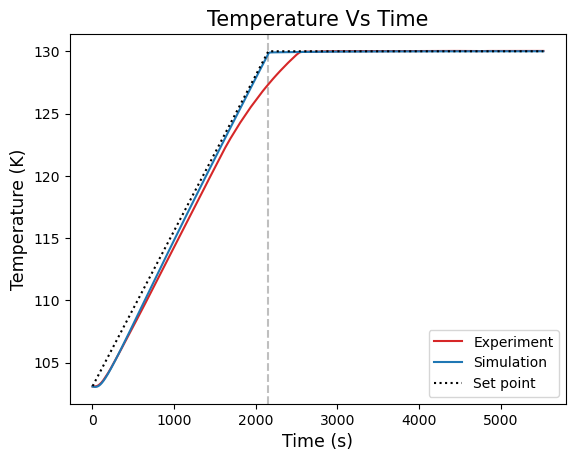

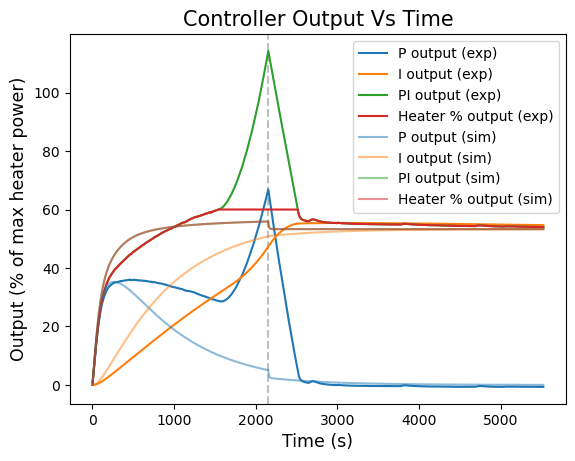

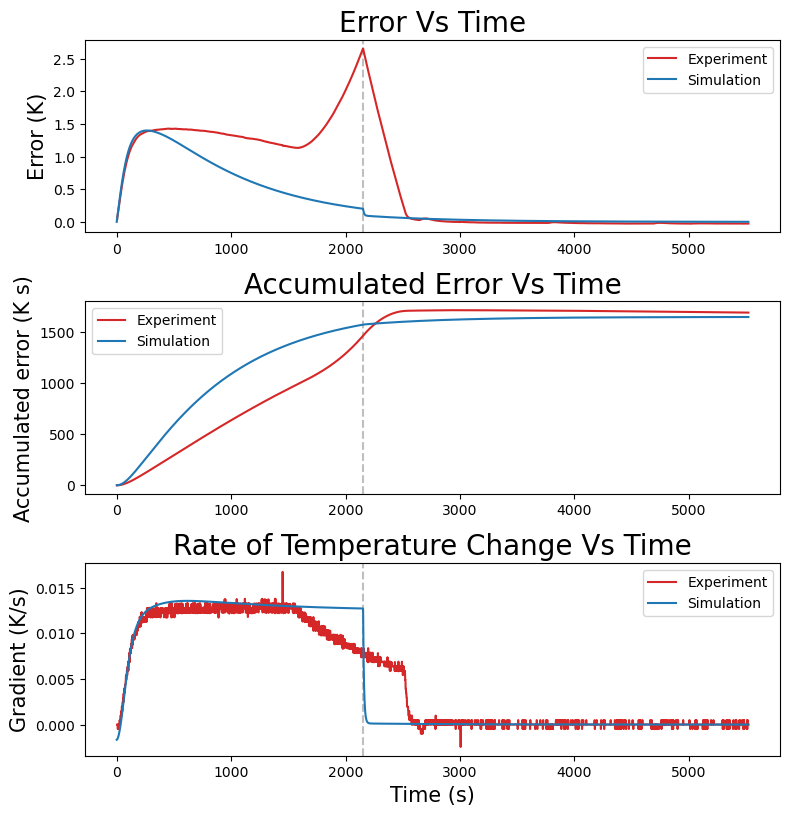

In [35]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1 = plt.gca()
ax1.axvline(2152.0, color='grey', alpha=0.5, linestyle='--')

#ax1.annotate('Overshoot suggests \nproportional term \nis too high', xy=(8000.0, 130), xytext=(3100, 120),
#            arrowprops=dict(facecolor='grey', shrink=0.05, width=2),)

ax1.plot(time_PID, temp_PID, label='Experiment', color='tab:red')
ax1.plot(time, temp[:-1], label='Simulation', color='tab:blue')
#ax1.plot(maxTempTime, maxTempTemp[:-1], label='maxTemp Simulation', color='tab:orange')
#ax1.plot(minTempTime, minTempTemp[:-1], label='minTemp Simulation', color='tab:green')
ax1.plot(time_PID, setpoint_PID, label='Set point', color='black', linestyle=':')
ax1.set_title('Temperature Vs Time',fontsize=15)
ax1.set_xlabel('Time (s)',fontsize=12.5)
ax1.set_ylabel('Temperature (K)',fontsize=12.5)
ax1.legend(loc='lower right')

fig2, ax2 = plt.subplots()
ax2 = plt.gca()
ax2.axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax2.plot(time_PID, P_out_PID, color='tab:blue', label='P output (exp)')
ax2.plot(time_PID, I_out_PID, color='tab:orange', label='I output (exp)')
ax2.plot(time_PID, PID_out_PID, color='tab:green', label='PI output (exp)')
ax2.plot(time_PID, M_out_PID, color='tab:red', label='Heater % output (exp)')
ax2.plot(controlTime, P_out, color='tab:blue', label='P output (sim)', alpha=0.5)
ax2.plot(controlTime, I_out, color='tab:orange', label='I output (sim)', alpha=0.5)
ax2.plot(controlTime, PID_out, color='tab:green', label='PI output (sim)', alpha=0.5)
ax2.plot(controlTime, duty, color='tab:red', label='Heater % output (sim)', alpha=0.5)
ax2.set_title("Controller Output Vs Time",fontsize=15)
ax2.set_xlabel("Time (s)",fontsize=12.5)
ax2.set_ylabel("Output (% of max heater power)",fontsize=12.5)
ax2.legend()

fig3, ax3 = plt.subplots(3, 1, figsize=(8,8))
ax3[0].axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax3[0].set_title('Error Vs Time',fontsize=20)
ax3[0].plot(time_PID, error_PID, label='Experiment', color='tab:red')
ax3[0].plot(controlTime, error, label='Simulation', color='tab:blue')
ax3[0].set_ylabel('Error (K)',fontsize=15)
ax3[0].legend(loc='best')
ax3[1].axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax3[1].set_title('Accumulated Error Vs Time',fontsize=20)
ax3[1].plot(time_PID, intError_PID, label='Experiment', color='tab:red')
ax3[1].plot(controlTime, intError, label='Simulation', color='tab:blue')
ax3[1].set_ylabel('Accumulated error (K s)',fontsize=15)
ax3[1].legend(loc='best')
ax3[2].axvline(2152.0, color='grey', alpha=0.5, linestyle='--')
ax3[2].set_title('Rate of Temperature Change Vs Time',fontsize=20)
ax3[2].plot(time_PID[1:], gradient_PID[1:], label='Experiment', color='tab:red')
ax3[2].plot(controlTime[1:], gradient, label='Simulation', color='tab:blue')
ax3[2].set_ylabel('Gradient (K/s)',fontsize=15)
ax3[2].legend(loc='best')
plt.tight_layout()
plt.xlabel('Time (s)',fontsize=15)

plt.show()

In [42]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1 = plt.gca()
#ax1.axvline(2152.0, color='grey', alpha=0.5, linestyle='--')

ax1.annotate('Overshoot suggests \nproportional term \nis too high. \nSolvable with set \npoint ramping.', xy=(8000.0, 130), xytext=(9000, 117),
            arrowprops=dict(facecolor='grey', shrink=0.05, width=2),)

ax1.plot(time_PID, temp_PID, label='Experiment', color='tab:red')
ax1.plot(time, temp[:-1], label='Simulation', color='tab:blue')
ax1.plot(time_PID, setpoint_PID, label='Set point', color='black', linestyle=':')
ax1.set_title('Temperature Vs Time',fontsize=15)
ax1.set_xlabel('Time (s)',fontsize=12.5)
ax1.set_ylabel('Temperature (K)',fontsize=12.5)
ax1.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


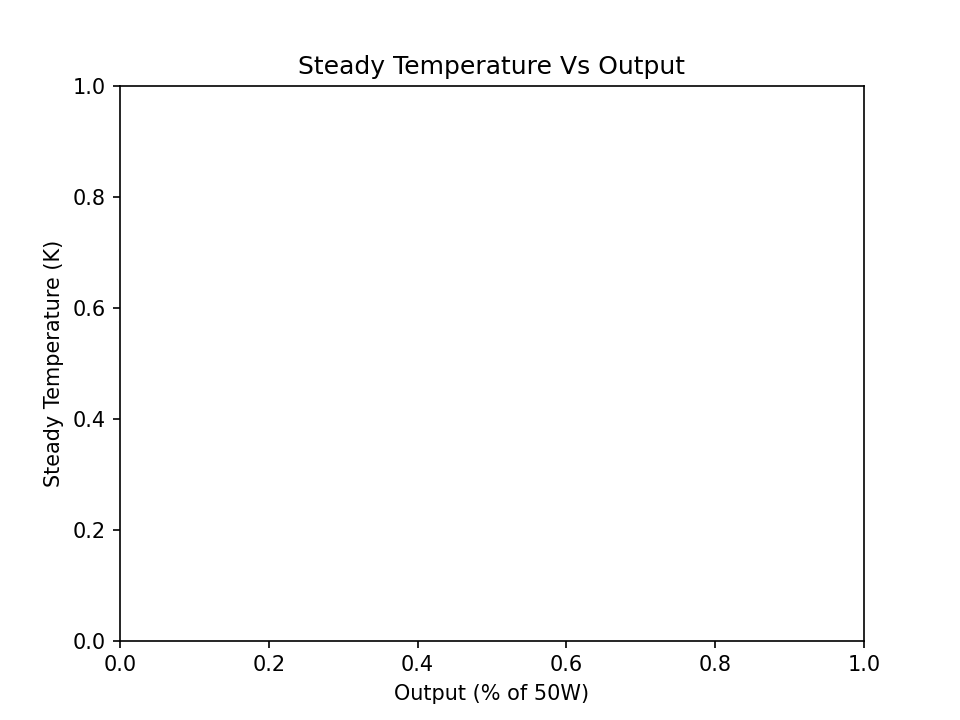

NameError: name 'steadyTemp' is not defined

In [9]:
#print(tauTempData, tauTempFit)
fig3, ax3 = plt.subplots()
ax3 = plt.gca()
ax3.set_title('Steady Temperature Vs Output')
ax3.set_xlabel('Output (% of 50W)')
ax3.set_ylabel('Steady Temperature (K)')
ax3.plot(outputList, steadyTemp)

fig4, ax4 = plt.subplots()
ax4 = plt.gca()
ax4.set_title('Tau Vs Output')
ax4.set_xlabel('Tau (a)')
ax4.set_ylabel('Steady Temperature (K)')
ax4.plot(outputList, tauFit)

In [ ]:
fig2, ax2 = plt.subplots()
ax2 = plt.gca()
ax2.set_title('Temperature Vs Log Time')
ax2.set_xlabel('Log Time')
ax2.set_ylabel('Temperature (K)')       

for k in range(0, len(outputSet)):
    time = resultArrs[k][0]; temp = resultArrs[k][1]
    time = list(map(float, time))
    time = np.array(time) - time[0]
    temp = list(map(float, temp))
    ax2.plot(np.log(time), temp, label=str(outputList[k]))
ax2.legend()
plt.plot()

In [45]:
print(temp_PID[0])